<center><h1>ClimatePy</h1></center>

### Environment Setup

In [1]:
# Package dependencies
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline

# SQLAlchemy Object Relational Mapper (ORM)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

### ORM Setup

In [2]:
# Create SQLite Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [3]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

* Calculate the date 1 year ago from the last data point in the database
* Perform a query to retrieve the data and precipitation scores
* Save the query results as a Pandas DataFrame and set the index to the date column
* Sort the dataframe by date
* Use Pandas Plotting with Matplotlib to plot the data

#### Latest Year Query

In [5]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
conn = engine.connect()

year = pd.read_sql('''SELECT m.date AS Date, SUM(m.prcp) AS Precipitation
                      FROM measurement AS m
                      LEFT JOIN station AS s 
                      ON m.station = s.station
                      GROUP BY m.date
                      ORDER BY m.date ASC;''', conn)

year = year[year['Date'] >= '2016-08-23']

#### Total Year Precipitation Plot

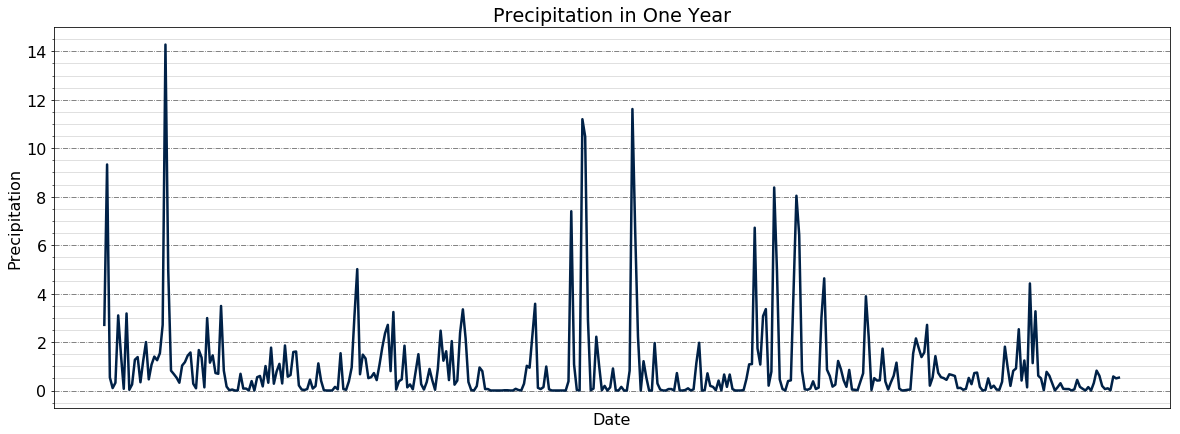

In [6]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots(1, figsize = [20, 7])

ax.plot(
    year['Date'], 
    year['Precipitation'], 
    color = '#002147',
    lw = 2.5
)

ax.set_ylabel('Precipitation')
ax.set_xlabel('Date')
ax.set_title('Precipitation in One Year')

x = plt.gca().xaxis
x.set_major_locator(locator)
x.set_major_formatter(fmt)

plt.grid(b = True, which = 'major', color = '#666666', linestyle = '-.')
plt.minorticks_on()
plt.grid(b = True, which = 'minor', color = '#666666', linestyle = '-', alpha = 0.25)

plt.savefig('Preciptation in One Year.png')

plt.show()

In [7]:
year['Precipitation'].describe()

count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: Precipitation, dtype: float64

![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
